# Динамика заболеваемости

Данные к онлайн-приложению https://epistat.wiv-isp.be

Колонки

-    Age age of the patient (in years);
-    DateMonday date of the Monday of the week of report: we are dealing with weekly data;
-    Gender gender of the patient;
-    Subject category of the disease, e.g. SALM for Salmonella;
-    NUTS2 administrative subdivision of Belgium where the case was reported.


https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5003365/



## Работа с интерактивным сайтом

Изучите явления:

1. Сезонность - Аденовирус, пневмония, хламидия, параинфлюенза

2. Согласие в 2014 между динамикой бореллии и ротавируса

3. Влияние фактора возраста - аденовирус, ВИЧ, пневмония

## Работа с данными

Загрузим набор данных и попробуем автоматизировать некоторые задачи.

In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
import re

Populating the interactive namespace from numpy and matplotlib


In [2]:
D = pd.read_csv("epistat.csv")  #https://epistat.wiv-isp.be/data/public_cases.csv")
D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295320 entries, 0 to 295319
Data columns (total 5 columns):
Age           289056 non-null float64
DateMonday    295320 non-null object
Gender        295320 non-null object
Subject       295320 non-null object
NUTS2         282641 non-null float64
dtypes: float64(2), object(3)
memory usage: 11.3+ MB


Как видно из количества ненулевых значений в наборе данных есть незначительное количество пропусков в данных о возрасте и регионе.


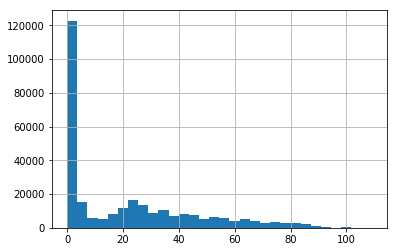

In [3]:
D.Age.hist(bins=30);

На гистограмме выделяются две возрастные группы, подверженные инфекционным заболеваниям - дети до 7 лет и молодежь после 20.

In [4]:
D.Gender.value_counts()

M      151441
F      140440
U        2316
UNK      1123
Name: Gender, dtype: int64

Пол хоть и указан во всех записях, но обозначения U и UNK вставлены на местах отсутствующих значений.

In [5]:
D.loc[D.Gender.isin(['U','UNK']), 'Gender'] = NaN
D.Gender.value_counts()

M    151441
F    140440
Name: Gender, dtype: int64

Информация о возбудителях закодирована коротким кодом.

In [6]:
D.Subject.value_counts()

V_RSV     65945
CAM_SP    54545
CHLTRA    34782
SALM      26764
V_RTV     17332
V_ADV     12355
BRRBUR    12283
GIA_SP    10109
HIV        9006
V_PIV      8412
PNEU       8291
NEIGON     7727
V_HCV      7596
CRS_SP     3187
BORPER     2998
SHIG       2941
STRPYO     2612
YERENT     2211
ENTHIS     1555
V_HAV      1302
HAEINF      839
V_HTV       668
LIS_SP      579
MENI        558
VTEC        510
CHIK        135
CHLPSI       77
ZIKA          1
Name: Subject, dtype: int64

Преобладают простудные и кишечные инфекции. Странный единичный случай [вируса Зика](https://ru.wikipedia.org/wiki/Вирус_Зика).

In [7]:
D[D.Subject=='ZIKA']

,Age,DateMonday,Gender,Subject,NUTS2
247437,27.0,2015-12-07,F,ZIKA,31.0


Короткие кодовые названия часто используются в больших таблицах для формирования колонок фиксированной ширины. Также короткие обозначения удобны для подписей в рисунках. Однако латинские названия возбудителей гораздо понятнее. 

Ниже приведен словарик соответствия кода и латинского названия. Структура данных `dict` используется для удобного доступа к множеству значений по ключу (коду).

In [8]:
kod_spec = {
    'BORPER':'Bordetella pertussis',
    'BRRBUR':'Borrelia burgdorferi',
    'CAM_SP':'Campylobacter sp.',
    'CHIK  ':'Chikungunya virus',
    'CHLPSI':'Chlamydia psittaci',
    'CHLTRA':'Chlamydia trachomatis',
    'CRS_SP':'Cryptosporidium',
    'ENTHIS':'Entamoeba histolytica',
    'GIA_SP':'Giardia sp.',
    'HAEINF':'Haemophilus influenzae',
    'HIV   ':'Lentivirus "HIV"',
    'LIS_SP':'Listeria monocytogenes',
    'MENI  ':'Neisseria meningitidis',
    'NEIGON':'Neisseria gonorrhoeae',
    'PNEU  ':'Streptococcus pneumoniae',
    'SALM  ':'Salmonella',
    'SHIG  ':'Shigella',
    'STRPYO':'Streptococcus pyogenes',
    'VTEC  ':'Escherichia coli "VTEC"',
    'V_ADV ':'Adenovirus',
    'V_HAV ':'Hepatitis A virus',
    'V_HCV ':'Hepatitis C virus',
    'V_HTV ':'Hantavirus',
    'V_PIV ':'Parainfluenza',
    'V_RSV ':'Respiratory Syncytial Virus',
    'V_RTV ':'Rotavirus',
    'YERENT':'Yersinia enterocolitica',
    'ZIKA  ':'Flavivirus "ZIKA"',
}
# пробелы проще вычистить в цикле
kod_spec = {k.strip():v for k,v in kod_spec.items()}
kod_spec

{'BORPER': 'Bordetella pertussis',
 'BRRBUR': 'Borrelia burgdorferi',
 'CAM_SP': 'Campylobacter sp.',
 'CHIK': 'Chikungunya virus',
 'CHLPSI': 'Chlamydia psittaci',
 'CHLTRA': 'Chlamydia trachomatis',
 'CRS_SP': 'Cryptosporidium',
 'ENTHIS': 'Entamoeba histolytica',
 'GIA_SP': 'Giardia sp.',
 'HAEINF': 'Haemophilus influenzae',
 'HIV': 'Lentivirus "HIV"',
 'LIS_SP': 'Listeria monocytogenes',
 'MENI': 'Neisseria meningitidis',
 'NEIGON': 'Neisseria gonorrhoeae',
 'PNEU': 'Streptococcus pneumoniae',
 'SALM': 'Salmonella',
 'SHIG': 'Shigella',
 'STRPYO': 'Streptococcus pyogenes',
 'VTEC': 'Escherichia coli "VTEC"',
 'V_ADV': 'Adenovirus',
 'V_HAV': 'Hepatitis A virus',
 'V_HCV': 'Hepatitis C virus',
 'V_HTV': 'Hantavirus',
 'V_PIV': 'Parainfluenza',
 'V_RSV': 'Respiratory Syncytial Virus',
 'V_RTV': 'Rotavirus',
 'YERENT': 'Yersinia enterocolitica',
 'ZIKA': 'Flavivirus "ZIKA"'}

В библиотеке `pandas` аналогом словаря  служит серия `pd.Series`, которая позволяет отбирать по нескольку названий по кодам.

In [9]:
species = pd.Series(kod_spec)
species

BORPER           Bordetella pertussis
BRRBUR           Borrelia burgdorferi
CAM_SP              Campylobacter sp.
CHIK                Chikungunya virus
CHLPSI             Chlamydia psittaci
CHLTRA          Chlamydia trachomatis
CRS_SP                Cryptosporidium
ENTHIS          Entamoeba histolytica
GIA_SP                    Giardia sp.
HAEINF         Haemophilus influenzae
HIV                  Lentivirus "HIV"
LIS_SP         Listeria monocytogenes
MENI           Neisseria meningitidis
NEIGON          Neisseria gonorrhoeae
PNEU         Streptococcus pneumoniae
SALM                       Salmonella
SHIG                         Shigella
STRPYO         Streptococcus pyogenes
VTEC          Escherichia coli "VTEC"
V_ADV                      Adenovirus
V_HAV               Hepatitis A virus
V_HCV               Hepatitis C virus
V_HTV                      Hantavirus
V_PIV                   Parainfluenza
V_RSV     Respiratory Syncytial Virus
V_RTV                       Rotavirus
YERENT      

Если заглянуть в [исходный код веб-страницы](view-source:https://epistat.wiv-isp.be/) (нажать Ctrl-U на сайте Epistat), то можно найти много других расшифровок кодовых обозначений в таблице.

Определите, кто скрывается за аббревиатурами:

- TUBECULT  (неужели культ ютуба?)
- TREPAL
- HANTA


Код на JavaScript содержит также информацию о соответствии кодов провинций и названий.
Информацию о названиях региона можно извлечь с помощью регулярных выражений следующим образом.

In [10]:
s='''case 10:
          e.province = 'Brussels';
          break;
        case 21:
          e.province = 'Antwerp';
          break;
        case 22:
          e.province = 'Limburg';
          break;
        case 23:
          e.province = 'East Flanders';
          break;
        case 24:
          e.province = 'Flemish Brabant';
          break;
        case 25:
          e.province = 'West Flanders';
          break;
        case 31:
          e.province = 'Walloon Brabant';
          break;
        case 32:
          e.province = 'Hainaut';
          break;
        case 33:
          e.province = 'Liege';
          break;
        case 34:
          e.province = 'Luxembourg';
          break;
        case 35:
          e.province = 'Namur';
          break;
        default:
          e.province = 'Unknown'
      }'''
tutu = re.findall(r'case (?P<code>\d+):.+?\.province = \'(?P<name>[\w ]+?)\'', s, re.S)
tutu

[('10', 'Brussels'),
 ('21', 'Antwerp'),
 ('22', 'Limburg'),
 ('23', 'East Flanders'),
 ('24', 'Flemish Brabant'),
 ('25', 'West Flanders'),
 ('31', 'Walloon Brabant'),
 ('32', 'Hainaut'),
 ('33', 'Liege'),
 ('34', 'Luxembourg'),
 ('35', 'Namur')]

Пары значений NUTS2-провинция мы можем оформить в виде таблички.

In [11]:
A = pd.Series(dict(tutu), name='Province').to_frame()
A.index = A.index.astype(int)
A

,Province
10,Brussels
21,Antwerp
22,Limburg
23,East Flanders
24,Flemish Brabant
25,West Flanders
31,Walloon Brabant
32,Hainaut
33,Liege
34,Luxembourg


На всякий случай можем добавить численность населения провинций.

In [12]:
s='''switch (e.NUTS2) {
        case 10:
          e.incidence = 100000 / 1119088;
          break;
        case 21:
          e.incidence = 100000 / 1764773;
          break;
        case 22:
          e.incidence = 100000 / 844621;
          break;
        case 23:
          e.incidence = 100000 / 1445831;
          break;
        case 24:
          e.incidence = 100000 / 1086446;
          break;
        case 25:
          e.incidence = 100000 / 1164967;
          break;
        case 31:
          e.incidence = 100000 / 382866;
          break;
        case 32:
          e.incidence = 100000 / 1317284;
          break;
        case 33:
          e.incidence = 100000 / 1077203;
          break;
        case 34:
          e.incidence = 100000 / 271352;
          break;
        case 35:
          e.incidence = 100000 / 476835;
          break;
        default:
          e.incidence = 0.1
'''
tutu = re.findall(r'case (?P<code>\d+):.+?\.incidence = 100000 / (?P<num>\d+)', s, re.S)
popu = pd.Series(dict(tutu), name='Population')
popu.index = popu.index.astype(int)

A = A.join(popu)
A

,Province,Population
10,Brussels,1119088
21,Antwerp,1764773
22,Limburg,844621
23,East Flanders,1445831
24,Flemish Brabant,1086446
25,West Flanders,1164967
31,Walloon Brabant,382866
32,Hainaut,1317284
33,Liege,1077203
34,Luxembourg,271352


Для удобства можно создать новую колонку в исходной таблице.

In [13]:
D.NUTS2.unique()

array([32., 23., 22., 21., 10., 24., 31., nan, 33., 25., 35., 34.])

In [14]:
D.NUTS2 = D.NUTS2.fillna(0).astype(int)
A.loc[0, 'Province'] = '-'

D['Province'] = D.NUTS2.apply(lambda code: A.loc[code,'Province'])
D

,Age,DateMonday,Gender,Subject,NUTS2,Province
0,63.0,2008-01-07,F,BRRBUR,32,Hainaut
1,58.0,2008-01-07,F,STRPYO,23,East Flanders
2,0.0,2008-01-07,NaN,V_RSV,22,Limburg
3,1.0,2008-01-07,M,V_RSV,23,East Flanders
4,43.0,2008-01-07,F,CHLTRA,21,Antwerp
5,0.0,2008-01-07,F,V_RSV,21,Antwerp
6,21.0,2008-01-07,M,NEIGON,21,Antwerp
7,42.0,2008-01-07,M,V_HCV,21,Antwerp
8,26.0,2008-01-07,F,V_PIV,10,Brussels
9,15.0,2008-01-07,F,V_HAV,10,Brussels


Давайте попробуем ответить на вопросы...

### Задание на выявление корреляций

С каким заболеванием максимально коррелирует число случаев хламидиоза в Антверпене за весь период, отраженный в наборе данных
за период с 1990 по 2014


Один из хламидиозов - хламидиоз попугайчиков очень редкий. Наверно имеется в виду более распространенное ЗППП.

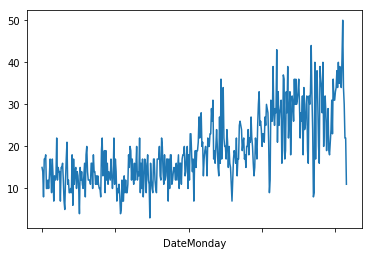

In [15]:
X = D[(D.Subject=='CHLTRA') & (D.Province == 'Antwerp')]
X.groupby('DateMonday').Subject.count().plot();

Мы видим рост заболеваемости. С какими наборами данных нужно провести корреляцию? Нужно получить динамику для всех инфекций в этом регионе.

In [16]:
X = D[(D.Province == 'Antwerp')]


Y = pd.pivot_table(X, 'Province', 'DateMonday', 'Subject', aggfunc='count', fill_value=0)
Y.plot();

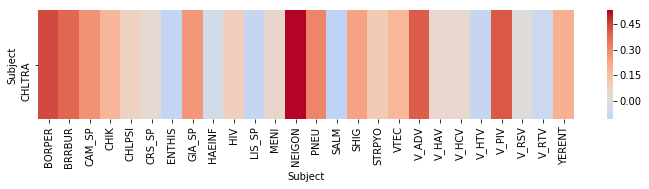

In [18]:
C = Y.corr()
figure(figsize=(12,2))
# удаляем пересечение с одноименной колонкой, потому что корреляция с самим собой всегда 1.0.
_C = C.loc[['CHLTRA']].T.drop('CHLTRA')

sns.heatmap(_C.T, cmap='coolwarm', center=0);

In [19]:
_C['CHLTRA'].argmax()

C:\a\WinPython\python-3.7.1.amd64\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


'NEIGON'

In [20]:
species[_C['CHLTRA'].argmax()]

C:\a\WinPython\python-3.7.1.amd64\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


'Neisseria gonorrhoeae'

In [21]:
_C.loc[_C['CHLTRA'].argmax()]

C:\a\WinPython\python-3.7.1.amd64\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


Subject
CHLTRA    0.529694
Name: NEIGON, dtype: float64

Корреляция 53% с динамикой другого ЗППП - гонореей.

### О нравах бельгийцев...

А что можно сказать про гендерные особенности заболеваемости гонореей?

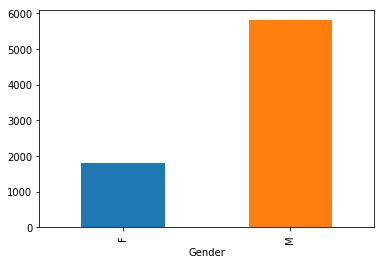

In [22]:
X = D[(D.Subject=='NEIGON')]
N = X.groupby('Gender').Subject.count()
N.plot(kind='bar');

Мужчины намного чаще болеют ЗППП. Если допустить что на каждую заболевшую женщину приходится один заболевший мужчина, то часть мужчин получили инфекцию иначе?

In [23]:
nMF = N.F
nMhomo = (N.M - nMF)

nMM = nMhomo / 2

nMM / nMF

1.1041436464088399

При прочих равных допущениях количество заражений внутри ММ пар в Бельгии на 10% больше, чем внутри MF пар. Остается только надеется, что разнополые пары не оказались в меньшинстве, а просто меньше болеют.

### См. также

- [Онлайн приложение для наблюдения за эпидемиями](https://dirk.shinyapps.io/surveillance/)
surveillance - пакет для Temporal and Spatio-Temporal Modeling and Monitoring of Epidemic Phenomena
